In [6]:
import numpy as np
import matplotlib.pyplot as plt

## Reaction-diffusion systems

In [65]:
a = 2.8e-4
b = 5e-3
tau = .1
k = -.005

In [66]:
size = 100  # size of the 2D grid
dx = 2. / size  # space step

T = 9.0  # total time
dt = .001  # time step
n = int(T / dt)  # number of iterations


In [67]:
def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright -
            4 * Zcenter) / dx**2

In [99]:
def show_patterns(U, ax=None):
    ax.imshow(U, cmap=plt.cm.viridis,
              interpolation='None')
           # extent=[-1, 1, -1, 1])
    ax.set_axis_off()

$$ \frac{\partial u}{\partial t} = a \Delta u + u - u^3 -v + k $$
$$ \tau \frac{\partial v}{\partial t} = b \Delta v + u  -v $$

In [106]:
U = np.random.rand(size, size)
V = np.random.rand(size, size)

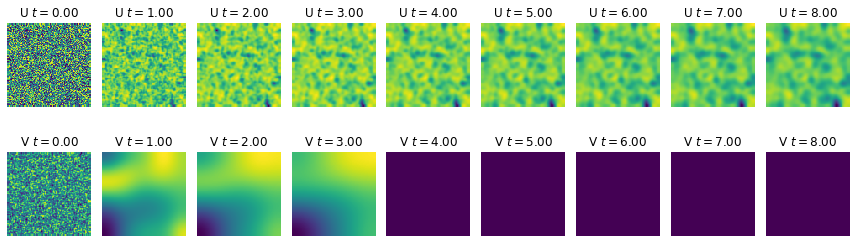

In [107]:
fig, axes = plt.subplots(2,9, figsize=(12, 4))
step_plot = n // 9
# We simulate the PDE with the finite difference
# method.
for i in range(n):
    # We compute the Laplacian of u and v.
    deltaU = laplacian(U)
    deltaV = laplacian(V)
    # We take the values of u and v inside the grid.
    Uc = U[1:-1, 1:-1]
    Vc = V[1:-1, 1:-1]
    
    # We update the variables.
    '''U[1:-1, 1:-1], V[1:-1, 1:-1] = \
        Uc + dt * (a * deltaU + Uc - Uc**3 - Vc + k),\
        Vc + dt * (b * deltaV + Uc - Vc) / tau'''
    U[1:-1, 1:-1], V[1:-1, 1:-1] = \
        Uc + dt * (a * deltaU + Uc - Uc**3 - Vc**2 + k),\
        Vc + dt * (b * deltaV + 2*k - Vc) / tau
    
    # Neumann conditions: derivatives at the edges
    # are null.
    for Z in (U, V):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]

    # We plot the state of the system at
    # 9 different times.
    if i % step_plot == 0 and i < 9 * step_plot:
        #ax = axes.flat[i // step_plot]
        ax = axes[0, i // step_plot]
        show_patterns(U, ax=ax)
        ax.set_title(f'U $t={i * dt:.2f}$')
        
        ax = axes[1, i // step_plot]
        show_patterns(V, ax=ax)
        ax.set_title(f'V $t={i * dt:.2f}$')
plt.tight_layout()

## Clark (2015)

In [7]:
def make_ccm_data(sp_sd=0.125, obs_sd=0.025, Sstr=0.375, times=10, burnin=100, number_of_chains=20, seednum=2718):
    # Set seed for generating random numbers
    np.random.seed(seednum)

    # Create empty lists to store results
    Accm = []
    Bccm = []
    time_ccm = []

    for i in range(number_of_chains):
        # Add process error to species intrinsic growth rates
        rx = 3.8 + np.random.normal(0, sp_sd)
        ry = 3.6 + np.random.normal(0, sp_sd)

        # Simulate competition
        x = np.zeros(times + burnin)
        y = np.zeros(times + burnin)
        x[0] = np.random.uniform()
        y[0] = np.random.uniform()
        
        for ii in range(1, times + burnin):
            x[ii] = x[ii-1] * (rx - rx * x[ii-1] - Sstr * y[ii-1])
            y[ii] = y[ii-1] * (ry - ry * y[ii-1])

            # Reflecting boundaries for population >1 or <0
            while x[ii] < 0 or x[ii] > 1:
                if x[ii] < 0:
                    x[ii] = -x[ii]
                if x[ii] > 1:
                    x[ii] = 1 + (1 - x[ii])

            while y[ii] < 0 or y[ii] > 1:
                if y[ii] < 0:
                    y[ii] = -y[ii]
                if y[ii] > 1:
                    y[ii] = 1 + (1 - y[ii])
        
        # Remove data from burnin time
        x = x[burnin:]
        y = y[burnin:]

        # Add multiplicative observation error
        x = x * np.random.lognormal(0, obs_sd, len(x))
        y = y * np.random.lognormal(0, obs_sd, len(y))

        # Save variables
        Accm.extend([np.nan] + list(x))
        Bccm.extend([np.nan] + list(y))
        time_ccm.extend([np.nan] + list(range(1, times + 1)))

    return {'Accm': Accm, 'Bccm': Bccm, 'time_ccm': time_ccm}

In [13]:
# Example usage
result = make_ccm_data(times=100, number_of_chains=1)

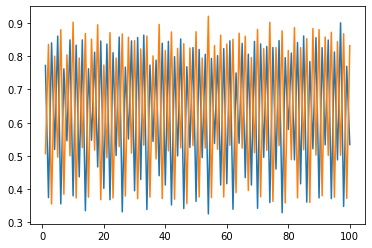

In [14]:
plt.plot(result['time_ccm'], result['Accm'])
plt.plot(result['time_ccm'], result['Bccm'])